### Mccreight - suffixlinks
Mccreight enables us to contruct a suffixtree in linear time O(n). This is done by switching between a fast and slow search for when looking if a current suffix fits into the tree. this is done by using a suffix link. the link in short allows us to jump to where a suffix should be inserted instead of looking through the tree from the root again

['$', 'aab$', 'ab$', 'b$', 'baab$']


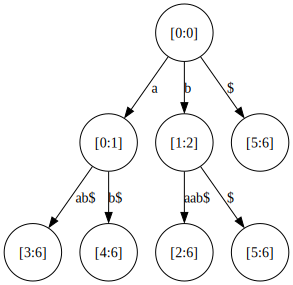

In [3]:
class Node(object):

    def __init__(self, string):
        self.start = 0
        self.end = 0
        self.children = {}
        self.parent = None
        self.suffix_link = None
        self.string = string

    def add_node(self, start, end):
        """
        setup a new node
        """
        child = Node(self.string)
        child.start, child.end = start, end
        child.parent = self
        self[self.string[start]] = child
        return child

    def split_edge(self, split_location):
        """
        split an edge, adjusting self to be internal node, and making new child node
        """
        start, end = self.start, self.end
        self.end = split_location
        child = Node(self.string)
        child.start, child.end = split_location, end
        child.parent = self
        child.children = self.children
        self.children = {}
        self[self.string[start]] = child

    @property
    def label(self):
        return repr(self.string[self.start : self.end])

    def __getitem__(self, ident):
        return self.children[ident]

    def __setitem__(self, ident, child):
        self.children[ident] = child

    def __str__(self, indent=0):
        return '%s%s\n%s' % (
            indent * '  ',
            self.label,
            ''.join(
                child.__str__(indent + 1)
                for key, child in sorted(self.children.iteritems())
            )
        )


class SuffixTree_mc:
    def __init__(self, string):
        self.string = string + "$"
        self.root = Node(self.string)
        self.build_tree()
    

    def fastscan(self, node, start, end):
        """
        Fastscan through the tree
        """
        distance = end - start
        if distance == 0:
            return node, node.start
        node = node[self.string[start]]
        while distance > node.end-node.start: 
            start += node.end-node.start    
            distance -= node.end-node.start   
            node = node[self.string[start]]
        return node, node.start + distance
    

    def slowscan(self, node, start, end):
        """
        slowscan into the tree
        """
        distance = 0
        loop = True
        try:
            node = node[self.string[start]]
            while start < end and loop:
                if node.start + distance < node.end:
                    if self.string[start] == self.string[node.start + distance]:
                        distance += 1
                        start += 1
                    else:
                        break
                else:
                    distance = 0
                    node = node[self.string[start + distance]]
        except KeyError:
            pass
        if distance > 0:
            node.split_edge(node.start + distance)
        leaf = node.add_node(start, end)
        return node, leaf



    def build_tree(self):
        string = self.string
        n = len(string)
        root = self.root                    #initialize the root
        head = root                         #set first head
        leaf = root.add_node(0, n)          #add node for first suffix
        for i in range(1, n):
            if head == root:                # case when head=""
                head, leaf = self.slowscan(root, leaf.start+1, leaf.end)
                continue
            parent = head.parent
            
            if parent == root:              #case when parent is root
                head_sufflink, j = self.fastscan(parent, head.start+1, head.end)
            
            else:
                head_sufflink, j = self.fastscan(parent.suffix_link, head.start, head.end)
            
            if j < head_sufflink.end:       # case when s(head) is on an edge
                head_sufflink.split_edge(j)
                new_head = head_sufflink
                leaf = new_head.add_node(leaf.start, leaf.end)
            
            else:                           # case when s(head) is a node
                new_head, leaf = self.slowscan(head_sufflink, leaf.start, leaf.end)
            head.suffix_link = head_sufflink
            head = new_head

        return root
    

##### visualization #####
    def visualize(self, filename="suffix_tree"):
        """
        Visualizes the suffix tree using Graphviz.
        """
        from graphviz import Digraph

        dot = Digraph(format="png")
        dot.attr("node", shape="circle")
        self._add_nodes_and_edges(self.root, dot)
        # dot.render(filename)      # render the file
        return dot
    def _add_nodes_and_edges(self, node, dot, parent_id=None):
        """
        recursively adds nodes and edges to the Graphviz graph.
        """
        node_id = id(node)
        label = f"[{node.start}:{node.end}]"
        dot.node(str(node_id), label=label)

        if parent_id is not None:
            edge_label = self.string[node.start:node.end]
            dot.edge(str(parent_id), str(node_id), label=edge_label)

        for child in node.children.values():
            self._add_nodes_and_edges(child, dot, node_id)


### validation ####
    def find_longest_branch(self):
        """
        Find the longest branch in the suffix tree using DFS.
        Returns both the longest string and the corresponding length.
        """
        def dfs(node, current_path):
            if not node.children:
                return current_path

            longest_branch = current_path
            for child in node.children.values():
                edge_label = self.string[child.start:child.end]
                branch = dfs(child, current_path + edge_label)
                if len(branch) > len(longest_branch):
                    longest_branch = branch
            return longest_branch

        return dfs(self.root, "")

    def get_all_suffixes(self):
        """
        Collect all suffixes from the suffix tree using DFS.
        Returns a list of all suffixes.
        """
        suffixes = []

        def dfs(node, current_path):
            if not node.children:
                suffixes.append(current_path)
                return

            for child in node.children.values():
                edge_label = self.string[child.start:child.end]
                dfs(child, current_path + edge_label)

        dfs(self.root, "")
        return suffixes

    def count_outgoing_edges(self):
        """
        Count the number of outgoing edges for internal nodes.
        Returns nodes that fail the criteria of having at least 2 children and at most
        the number of unique symbols in the string.
        """
        min_children = 2
        max_children = len(set(self.string))
        failed_nodes = []

        def dfs(node):
            if not node.children:
                return

            for child in node.children.values():
                dfs(child)

            num_children = len(node.children)
            if num_children < min_children or num_children > max_children:
                failed_nodes.append(node)

        dfs(self.root)
        return failed_nodes

    def check_unique_children(self):
        """
        Check that each internal node has unique child edges.
        Returns a list of failed nodes where children are not unique.
        """
        failed_nodes = []

        def dfs(node):
            if not node.children:
                return

            for child in node.children.values():
                dfs(child)

            all_children = list(node.children.values())
            unique_children = set(all_children)
            if len(all_children) != len(unique_children):
                failed_nodes.append(node)

        dfs(self.root)
        return failed_nodes

    def node_visits(self):
        """
        Check if any node is visited more than once during a DFS.
        Returns a list of failed nodes visited more than once.
        """
        visit_counts = {}
        failed_nodes = []

        def dfs(node):
            for child in node.children.values():
                dfs(child)

            if node in visit_counts:
                visit_counts[node] += 1
            else:
                visit_counts[node] = 1

            if visit_counts[node] > 1:
                failed_nodes.append(node)

        dfs(self.root)
        return failed_nodes

    def df_numbering(self):
        """
        Perform depth-first numbering of leaves.
        Adds df_number and leaf_range to nodes and returns lists of suffix and df-numbers.
        """
        count = [0]
        df_list = []
        suffix_list = []

        def dfs(node):
            if not node.children:
                node.df_number = count[0]
                node.leaf_range = (count[0], count[0])
                count[0] += 1
                df_list.append(node.df_number)
                suffix_list.append(node.suffix_number)
                return node.leaf_range

            min_df = float("inf")
            max_df = -float("inf")
            for child in node.children.values():
                child_leaf_range = dfs(child)
                min_df = min(min_df, child_leaf_range[0])
                max_df = max(max_df, child_leaf_range[1])

            node.leaf_range = (min_df, max_df)
            return node.leaf_range

        dfs(self.root)
        return suffix_list, df_list

    def df_numbering_non_recursive(self):
        """
        Perform depth-first numbering of leaves using a non-recursive approach.
        Returns lists of suffix and df-numbers.
        """
        count = 0
        df_list = []
        s_list = []

        stack = [(self.root, None, None)]
        visited_children = {}

        while stack:
            node, min_df, max_df = stack.pop()

            if not node.children:
                node.df_number = count
                node.leaf_range = (count, count)
                df_list.append(node.df_number)
                s_list.append(node.suffix_number)
                count += 1
                continue

            if node not in visited_children:
                visited_children[node] = 0
                min_df, max_df = float("inf"), -float("inf")

            children = list(node.children.values())
            if visited_children[node] < len(children):
                child = children[visited_children[node]]
                visited_children[node] += 1
                stack.append((node, min_df, max_df))
                stack.append((child, None, None))
            else:
                for child in children:
                    min_df = min(min_df, child.leaf_range[0])
                    max_df = max(max_df, child.leaf_range[1])
                node.leaf_range = (min_df, max_df)

        return s_list, df_list




suffix_tree = SuffixTree_mc("abaab")
# adadaada$
# dadaada$
# adaada$
# daada$
# aada$
# ada$
# da$
# a$
# $
# print(suffix_tree.root.children[""])
#['$', 'a$', 'aada$', 'ada$', 'adaada$', 'adadaada$', 'da$', 'daada$', 'dadaada$']
#['$', 'a$', 'aada$', 'ada$', 'da$', 'daada$', 'dadaada$']
print(sorted(suffix_tree.get_all_suffixes()))
suffix_tree.visualize()

Creates the correct tree for a string: "mississippi"
Creates wrong tree for string: "abaab"

In cases where it doesnt it seems like the first suffix is missing and the middle of sequences are missing

## validate the trees

In [4]:
def validate_suffix_tree(input_string, verbose = True):
    """
    collective function to use all the validation functions at the same time
    Returns a list where the indices corospond to the follow:
    ["input_string", "length_check", "spell_check", "all_same_suffix_check"]
    Verbose indicates if an output should be printed or if only the list should be returned
    """
    
    string_s = input_string + "$"
    suffix_tree = SuffixTree_mc(input_string)

    #### Find longest branch in suffix tree ##### + spellcheck
    longest_branch = suffix_tree.find_longest_branch()
    output_length= len(longest_branch)
    input_length = len(string_s)

    #### Double check every suffix is in tree ####
    actual_suffixes = sorted(suffix_tree.get_all_suffixes())
    expected_suffixes = sorted([string_s[i:] for i in range(len(string_s))])

    #### count edges ####
    failed_count_edges = suffix_tree.count_outgoing_edges()
    count_check = False
    if failed_count_edges == []:
        count_check = True

    #### unique children ####
    failed_unique_children = suffix_tree.check_unique_children()
    unique_child_check = False
    if failed_unique_children == []:
        unique_child_check = True

    #### Node visits during depth-first search ####
    too_many_visits = suffix_tree.node_visits()
    visits_check = False
    if too_many_visits == []:
        visits_check = True

    if verbose == True:
        print("suffix_tree was generated with the string:  ", input_string)
        print("same length?  ", output_length == input_length, output_length, input_length)
        #### Spell checking ####
        print("spelled correctly?  ", longest_branch == string_s, longest_branch, string_s)
        print("obs suffixes:  ", actual_suffixes)
        print("exp suffixes:  ", expected_suffixes)
        print("All suffixes same?  ", actual_suffixes == expected_suffixes)
        print("All internal nodes have correct number of children?  ", count_check)
        print("All internal nodes have unique children?  ", unique_child_check)
        print("All nodes were only visited once?  ", visits_check)


    return [input_string, 
            output_length==input_length, 
            longest_branch == string_s, 
            actual_suffixes == expected_suffixes,
            count_check,
            unique_child_check,
            visits_check]


string = "abaab"
validate_suffix_tree(string, verbose=True)

suffix_tree was generated with the string:   abaab
same length?   False 5 6
spelled correctly?   False baab$ abaab$
obs suffixes:   ['$', 'aab$', 'ab$', 'b$', 'baab$']
exp suffixes:   ['$', 'aab$', 'ab$', 'abaab$', 'b$', 'baab$']
All suffixes same?   False
All internal nodes have correct number of children?   True
All internal nodes have unique children?   True
All nodes were only visited once?   True


['abaab', False, False, False, True, True, True]

The testing further showcases that there is an error the way some of the suffixes inserted, 
specifically the longer suffixes are missing. Seems that the string of only a single character "aaaa" works fine.<

In [354]:
import random 

def random_input_string(n, symbols):
    """
    creates a string of the specified length n with randomly selected symbols from the allowed
    ones indicated by symbols.
    """
    return ''.join(random.choice(symbols) for i in range(n))

test_duration = 10000
n = 100
symbols = 'agct'

for i in range(test_duration):
    string = random_input_string(n, symbols)
    
    checks = validate_suffix_tree(string, verbose=False)
    len_check = checks[1]
    spell_check = checks[2]
    suffix_check = checks[3]
    count_check = checks[4]
    child_check = checks[5]
    visits_check = checks[6]

    # if any check fails break loop and report
    if len_check == False or spell_check == False or suffix_check == False or count_check == False or child_check == False or visits_check == False:
        print("Test failed with:", string)
        print("length:", len_check)
        print("spelling:", spell_check)
        print("suffix_check:", suffix_check)
        print("count_check:", count_check)
        print("unique child check:", child_check)
        print("visits check:", visits_check)
        break

# if nothing is returned, there is no complaints

KeyError: 'g'

## Runtime test

In [322]:
import time 

def measure_time(func, *args, **kwargs):
    """
    Measure the time it takes to run a function
    """
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return elapsed_time, result

In [323]:
# import functions from other scripts
from suffixtree_construction import *

### Testcase: only a's string

In [351]:
import matplotlib.pyplot as plt

#Size of input strings
string_lengths_a = range(100, 2000, 200)  

runtimes_func1_a = []
runtimes_func1_a_n = []
runtimes_func1_a_n2 = []
runtimes_func2_a = []
runtimes_func2_a_n = []
runtimes_func2_a_n2 = []


for length in string_lengths_a:
    test_string = 'a' * length  #generate only a string
    
    #measure for SuffixTree
    runtime_1, suffix_tree = measure_time(SuffixTree, test_string)
    runtimes_func1_a.append(runtime_1)
    runtimes_func1_a_n.append(runtime_1/length)
    runtimes_func1_a_n2.append(runtime_1/(length*length))

    #measure for SuffixTree_mc
    runtime_2, suffix_tree = measure_time(SuffixTree_mc, test_string)
    runtimes_func2_a.append(runtime_2)
    runtimes_func2_a_n.append(runtime_2/length)
    runtimes_func2_a_n2.append(runtime_2/(length*length))

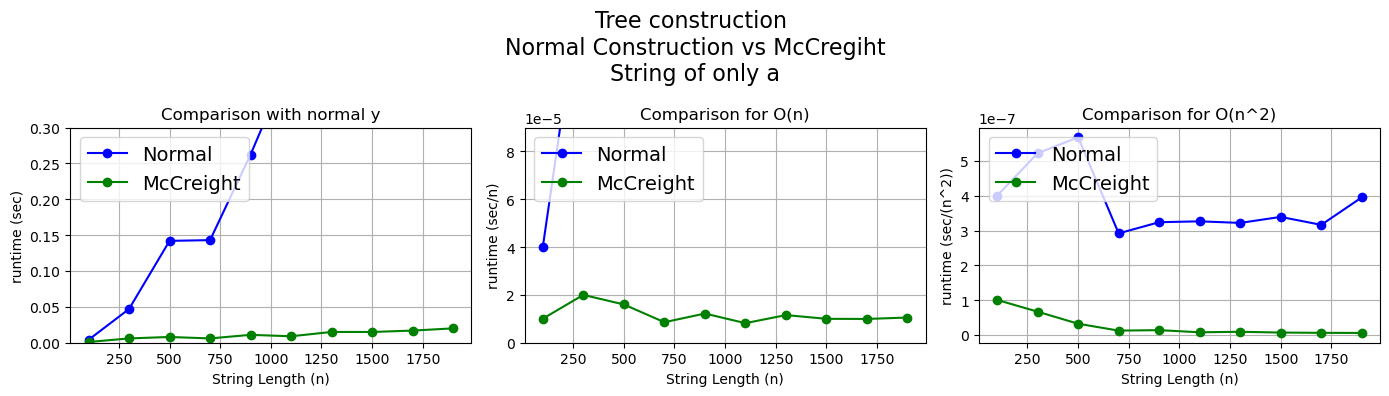

In [356]:
#create subplots:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Tree construction \nNormal Construction vs McCregiht\nString of only a', fontsize=16)


# plot1 - y unmanipulated
axes[0].plot(string_lengths_a, runtimes_func1_a, marker='o', color='blue', label="Normal")
axes[0].plot(string_lengths_a, runtimes_func2_a, marker='o', color='green', label="McCreight")
axes[0].set_title('Comparison with normal y')
axes[0].set_xlabel('String Length (n)')
axes[0].set_ylabel('runtime (sec)')
axes[0].set_ylim(0, 0.3)
axes[0].grid(True)
axes[0].legend(fontsize = 14, loc = "upper left")


# plot2 - y divided by n
axes[1].plot(string_lengths_a, runtimes_func1_a_n, marker='o', color='blue', label="Normal")
axes[1].plot(string_lengths_a, runtimes_func2_a_n, marker='o', color='green', label="McCreight")
axes[1].set_title('Comparison for O(n)')
axes[1].set_xlabel('String Length (n)')
axes[1].set_ylabel('runtime (sec/n)')
axes[1].set_ylim(0, 0.00009)
axes[1].grid(True)
axes[1].legend(fontsize = 14, loc = "upper left")


# plot3 - y divided by n^2
axes[2].plot(string_lengths_a, runtimes_func1_a_n2, marker='o', color='blue', label="Normal")
axes[2].plot(string_lengths_a, runtimes_func2_a_n2, marker='o', color='green', label="McCreight")
axes[2].set_title('Comparison for O(n^2)')
axes[2].set_xlabel('String Length (n)')
axes[2].set_ylabel('runtime (sec/(n^2))')
axes[2].grid(True)
# axes[2].set_ylim(0, 0.00000003)
axes[2].legend(fontsize = 14, loc = "upper left")


#adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("Plots/Tree_construction_comparison_MC_v1.png", dpi = 600)
plt.show()

Since the algorithm is not always making the correct trees, this runtime test cant be fully relied upon. However zooming, it can be seen that the McCreight algorithm is constant in the middle panel and slightly linear in the first
This indicates a linear runtime. But can only be confirmed when the algorithm is complete.